In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import figure, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.optimize import curve_fit
import radioactivedecay as rd
from mendeleev import element


plt.rc("xtick", labelsize=10, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=10, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes", grid=True, linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid", ls=":", lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=10) #Font og fontstørrelse
plt.rc("figure", figsize=(6,3), dpi=150) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major", width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major", width=1.3) #Sætter tykkelsen på xticks

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#### paths ####  # Zn 0.37 resten cobber. 
# TODO: 1 kør med korrekt combination af mseeing 
# 2 kør med deres energi og se om de samme nuclei skabes som dem
# 3 fix sobp.dat fil og prøv at kør den treatmentplan uden collimator og med collimator 

absolute_path = os.path.abspath('').rstrip("/python_notebook")
brass20_1p25_paths = glob.glob(absolute_path + "/Full_Sim/20brass1p25mm/20brass1p25*sum.lis")
brass20_1p25_paths.sort()

# all these are dz = 50 mm 
brass1p0_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p0mm/50brass1p0*sum.lis")
brass1p0_paths.sort()
brass1p27_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p27mm/50brass1p27*sum.lis")
brass1p27_paths.sort()
brass1p5_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p5mm/50brass1p5*sum.lis")
brass1p5_paths.sort()

nbrass1p27_paths = glob.glob(absolute_path + "/Full_Sim/n50brass1p27mm/n50brass1p27*sum.lis")
nbrass1p27_paths.sort()

tungsten1p0_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p0mm/20tungsten1p0*sum.lis")
tungsten1p0_paths.sort()
tungsten1p27_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p27mm/20tungsten1p27*sum.lis")
tungsten1p27_paths.sort()
tungsten1p5_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p5mm/20tungsten1p5*sum.lis")
tungsten1p5_paths.sort()

sobp_path = absolute_path + "/sobp_format.dat"

treatmentplan_no_grid=glob.glob(absolute_path + "/correct_treatmentplan/no_grid/treatment_simulation_*_plot.dat")
treatmentplan_no_grid.sort()

test_script = glob.glob(absolute_path + "/reliability/recreation_*_sum.lis")
test_script.sort()

In [3]:
columns = ["E", "dE", "X", "Y", "FWHMx", "FWHMy", 1, 2, 3, 4, "W"]
sobp_data = pd.DataFrame(np.loadtxt(sobp_path, skiprows=2), columns=columns)
sobp_data = sobp_data.drop(columns=[1,2,3,4])

In [4]:
fmt = '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%.8e'
#np.savetxt(absolute_path + "/correct_treatmentplan/sobp.dat", sobp_data.values, delimiter=', ', fmt=fmt)

In [5]:
cool_times_dict = {
    "cool1": 300, "cool2": 900, "cool3": 3600, "cool4": 7200, "cool5": 14400, "cool6": 28800, "cool7": 57600,
    "cool8": 86400, "cool9": 115200, "cool10": 259200, "cool11": 450, "cool12": 1400, "cool13": 2500, 
    "cool14": 5400, "cool15": 10800, "cool16": 360000, "cool17": 21600, "cool18": 43200, "cool19": 150,
    "cool20": 600, "cool30": 0
}

In [6]:
def load_dat_file(path: str, columns: list):
    data = np.loadtxt(path)
    columns.append("Unc")
    columns.append("Value")
    df = pd.DataFrame(data=data, columns=columns)
    return df
    

def get_df_tab(path: str) -> [pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(path)
    cool_time = cool_times_dict[df.iloc[0, 0].replace(" ", "")]
    vals = df.loc[df[df.columns[0]].str.contains("#")].index.values
    df_isotopes = df.iloc[vals[0]+1:vals[1], 0].str.split(expand = True).astype(float)
    df_isomer = df.iloc[vals[1]+1:, 0].str.split(expand = True).astype(float)
    df_isotopes.columns = ["A", "Z", "Bq", "dBq"]
    df_isotopes.columns.name = cool_time
    df_isomer.columns = ["A", "Z", "m", "Bq", "dBq"]
    df_isomer.columns.name = cool_time
    return df_isotopes, df_isomer

def get_df_sum(path: str, extra = False, number = 3) -> [pd.DataFrame, pd.DataFrame]:
    skipper = 18
    if extra:
        skipper = 194
    df = pd.read_csv(path, skiprows=skipper)
    vals = df.loc[df[df.columns[0]].str.contains("A")].index.values
    for i in range(len(vals)-1):
        if vals[i+1]-vals[i] <= 1:
            continue
        columns = df.iloc[vals[i], 0].split()[3:]
        dff = df.iloc[vals[i]+1:vals[i+1], 0].str.split(expand = True).reset_index().drop("index", axis=1)
        try:
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        except ValueError:
            dff = dff.drop(dff.tail(1).index)
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        ff.columns = columns
        dd = df.iloc[vals[i]+1:vals[i+1], 0]
        dd = dd.str.replace("+", "", regex=True)
        dd = dd.str.replace("/", "", regex=True)
        dd = dd.str.replace("-", "", regex=True)
        dd = dd.str.replace("%", "", regex=True)
        dd = dd.str.split(expand = True).reset_index().drop("index", axis=1)
        dg = dd.loc[1::2,:len(columns)-1].astype(float)
        dg.columns = columns
        dg.index = ff.index
        if i == 0:
            tot_df = ff
            tot_df_d = dg
        else:
            tot_df = pd.concat([tot_df, ff])
            tot_df_d = pd.concat([tot_df_d, dg])
    name = cool_times_dict[f"cool{int(path.split('_')[number])-20}"]
    tot_df_d.columns.name = name
    tot_df.columns.name = name
    return tot_df, tot_df_d
    
        
    
def plot_img(df: pd.DataFrame, pivot: bool, transpose = False) -> None:
    plt.figure(figsize=(7, 5))
    plt.title(f"Cooling time in sec = {df.columns.name}")
    ax = plt.gca()
    if pivot:
        data = df.pivot_table(index='Z', columns='A', values='Bq')
    else:
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value = df.index[-1]
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value2 = df.index[-1]
        aa = pd.DataFrame(index=range(last_value+1), columns =range(last_value2+1))
        aa.iloc[df.columns.values, df.index.values] = df.transpose().values
        data = aa.fillna(0)
    if transpose:
        data = data.transpose()
    im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=0.1, vmax=10000), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.xlabel("A")
    plt.ylabel("Z")
    plt.colorbar(im, cax=cax)
    plt.show()
    return 


def find_elements(df: pd.DataFrame, threshold: float, cool_in_sec=False) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[df[i] > threshold, i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    print("Cooling time =", df.columns.name if cool_in_sec else df.columns.name/60/60,
          "Seconds" if cool_in_sec else "Hours",
          f"| Threshold = {threshold:.0f}")
    return df_return.sort_values("Bq", ascending=False)


def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[:,i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    return df_return.fillna(0)


def indv_atom(paths: list, A: str, Z: str, number=3) -> list:
    values = []
    for i in paths:
        try:
            ff1, uncb = get_df_sum(i, number=number)
            values.append(ff1.loc[A, Z].sum())
        except Exception as e:
            print("error : ", e)
            values.append(0)
    return values


def plot_spec(type_: str, A: list, Z: list, number=3, ylog=False) -> None:
    paths = type_
    times = []
    
    for path in paths:
        times.append(cool_times_dict[f"cool{int(path.split('_')[number])-20}"])
        
    data = pd.DataFrame(index=times)
    for a, z in zip(A, Z):
        data[f"{a}, {z}"] = indv_atom(type_, a, z, number=number)
    data = data.sort_index()
    for i in data.columns:
        plt.plot(data.index.values/60/60, data[i].values, label=i)
    plt.xlabel("Hours")
    plt.ylabel("Bq")
    if ylog:
        plt.yscale("log")
    plt.legend()
    plt.show()
    
    return
    

def get_df_from_data(path: str, one_dim=False) -> pd.DataFrame:
    values = np.loadtxt(path)
    columns = ["z", "value", "error"] if one_dim else ["x", "y", "value", "error"]
    df = pd.DataFrame(data=values, columns=columns)
    return df
    
    
def plot_datfile(path, onedim=False) -> None:
    df = get_df_from_data(path, onedim)
    if onedim:
        plt.errorbar(df["z"].values, df["value"].values, yerr=df["error"].values, fmt="o", markersize=4
                     , capsize=5)
        plt.show()
    else:
        data = df.pivot_table(index='x', columns='y', values='value')
        fig, ax = plt.subplots(figsize=(20, 4))
        im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=data.min().min(), vmax=data.max().max())
                       , origin='lower')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.xlabel("A")
        plt.ylabel("Z")
        plt.colorbar(im, cax=cax)
        plt.show()

        
def get_val_unc(paths, number=3):
    times = []
    sums = []
    uncs = []

    for path in paths:
        try:
            df, unc = get_df_sum(path)
            sums.append(df.sum().sum())
            times.append(cool_times_dict[f"cool{int(path.split('_')[number])-20}"])
            df_unc = (df*unc/100)**2
            uncs.append((df_unc.sum().sum())**(1/2))
        except:
            print(path)
    
    return times, sums, uncs

def get_tot_df(paths: list, number=3):
    tungsten_paths = paths
    tot_df_tungsten, extra = get_df_sum(tungsten_paths[0], number=number)
    tot_df_tungsten = sort_df(tot_df_tungsten)

    for i in range(1, len(tungsten_paths)):
        path = tungsten_paths[i]
        df, extra = get_df_sum(path, number=number)
        tot_df_tungsten = pd.concat([tot_df_tungsten, sort_df(df)], join="inner")

    df_sums_tungsten = pd.pivot_table(tot_df_tungsten, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
    df_sums_tungsten = df_sums_tungsten.sort_values(by="Bq", ascending=False)
    df_sums_tungsten=df_sums_tungsten.loc[df_sums_tungsten["Bq"] > df_sums_tungsten.describe()["Bq"].loc["25%"]]
    return df_sums_tungsten


def funlin(x, a, gamma):
    return a*np.exp(-gamma*x) # no offset 


xlin = np.array([300, 900, 3600, 7200,14400,28800,57600,86400,115200,259200,450,
                 1400,2500,5400,10800,360000,21600,43200,150,600])


def fit_data(df, df_uncs, guess=[7e8, 0.00009], prints = False):
    ylin = df
    yler = df_uncs
    popt, pcov = curve_fit(funlin, xlin, ylin, p0=guess, sigma=yler, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    if prints:
        print('a:',popt[0],'    gamma :',popt[1])
        print('usikkerheder:',perr)
        print("halflife = ", 1/popt[1]/60/60, " hours +-", (1/popt[1]**4*perr[1]**2)**(1/2)/60/60)       
    return popt, perr


def add_plot(xs, ys, uncs, popt, perr, label, type_ = "o"):
    
    plt.plot(xs/60/60, funlin(xs, *popt), "--", color="black")
    plt.errorbar(xlin/60/60, ys, yerr=uncs, fmt=type_, markersize=4,
                 capsize=5, label=label)

    plt.fill_between(xs/60/60, funlin(xs, popt[0]-perr[0], popt[1]+perr[1], popt[2]-perr[2]),
                     funlin(xs, popt[0]+perr[0], popt[1]-perr[1], popt[2]+perr[2]), color="lightgrey")
    return



def add_plotx(xs, ys, uncs, popt, perr, label, type_ = "o"):
    plt.plot(xs/60/60, funlin(xs, *popt), "--", color="black")
    plt.errorbar(np.array(xlin)/60/60, ys, yerr=uncs, fmt=type_, markersize=4,
                 capsize=5, label=label)

    plt.fill_between(xs/60/60, funlin(xs, popt[0]-perr[0], popt[1]+perr[1]),
                     funlin(xs, popt[0]+perr[0], popt[1]-perr[1]), color="lightgrey")
    return


def catch(A, Z):
    try:
        output = rd.Nuclide(f'{element(Z).symbol}-{A}').half_life("readable")
    except:
        output = "No Data"
    return output


def plot_branch(A, Z):
    nuc = rd.Nuclide(f'{element(Z).symbol}-{A}')
    nuc.plot()
    plt.show()
    return


# Treatment plan

In [7]:
df = load_dat_file(treatmentplan_no_grid[0], ["Y", "X"])
df

,Y,X,Unc,Value
0,-10.0,-20.000000,6.280850e-16,41.7323
1,-10.0,-19.933333,2.486990e-15,89.3768
2,-10.0,-19.866667,1.281170e-10,88.7923
3,-10.0,-19.800000,1.889370e-09,82.5796
4,-10.0,-19.733333,2.600360e-08,90.4351
...,...,...,...,...
361196,10.0,19.733333,3.938200e-10,91.6318
361197,10.0,19.800000,1.704900e-09,99.2729
361198,10.0,19.866667,7.741970e-10,75.4805
361199,10.0,19.933333,1.288110e-09,63.1587


In [ ]:
x, y = np.meshgrid(df["X"], df["Y"])

In [ ]:

# Create plot
fig, ax = plt.subplots()
im = ax.imshow(df["value"], extent=[df["X"].min(), df["X"].max(), df["Y"].max(), df["Y"].min()])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("My Imshow Plot")
fig.colorbar(im)
plt.show()

# 20Brass1p25mm simulation results 

In [314]:
brass = get_tot_df(brass20_1p25_paths).reset_index()
b = brass.loc[brass["Bq"] > brass.describe()["Bq"].loc["25%"]].copy()
b["Half life"] = [catch(A, Z) for A, Z in zip(b["A"], b["Z"])]

In [322]:
# Compare with experimental results
b.loc[(b["A"].isin(["56", "18", "22", "56", "68", "60", "89", "103"])) &
      (b["Z"].isin([27, 18, 9, 11, 25, 31, 40, 44]))] 

,A,Z,Bq,Half life
11,68,31,2.368474e-03,67.71 m
22,56,25,2.161432e-04,2.5789 h
42,18,9,1.830909e-05,109.77 m
48,56,27,9.925000e-06,77.23 d
80,60,27,1.850700e-07,5.2713 y


In [315]:
b[:15]  # TOP 15

,A,Z,Bq,Half life
0,62,29,0.180320,9.673 m
1,11,6,0.132660,20.39 m
2,13,7,0.120378,9.965 m
3,63,30,0.042648,38.47 m
4,15,8,0.026706,122.24 s
5,61,29,0.024733,3.333 h
6,60,29,0.012853,23.7 m
7,64,29,0.005657,12.700 h
8,65,31,0.004131,15.2 m
9,62,30,0.002615,9.186 h


# 50Brass1p27mm simulation results 

In [230]:
nbrass = get_tot_df(nbrass1p27_paths).reset_index()
k = nbrass.loc[nbrass["Bq"] > nbrass.describe()["Bq"].loc["25%"]].copy()

In [231]:
k["Half life"] = [catch(A, Z) for A, Z in zip(k["A"], k["Z"])]

In [232]:
# Compare with experimental results
k.loc[(k["A"].isin(["56", "41", "18", "22", "56", "68", "60"])) &
      (k["Z"].isin([27, 18, 9, 11, 25, 31]))] 

,A,Z,Bq,Half life
10,68,31,1.194428e-03,67.71 m
20,56,25,9.122652e-05,2.5789 h
37,18,9,1.009721e-05,109.77 m
46,56,27,4.263000e-06,77.23 d
63,41,18,4.812374e-07,109.61 m
77,60,27,9.212000e-08,5.2713 y


In [233]:
k[:15]  # TOP 15¢

,A,Z,Bq,Half life
0,62,29,0.084522,9.673 m
1,11,6,0.044763,20.39 m
2,13,7,0.041411,9.965 m
3,63,30,0.020210,38.47 m
4,61,29,0.011210,3.333 h
5,15,8,0.009404,122.24 s
6,60,29,0.005794,23.7 m
7,64,29,0.002811,12.700 h
8,65,31,0.002114,15.2 m
9,62,30,0.001214,9.186 h


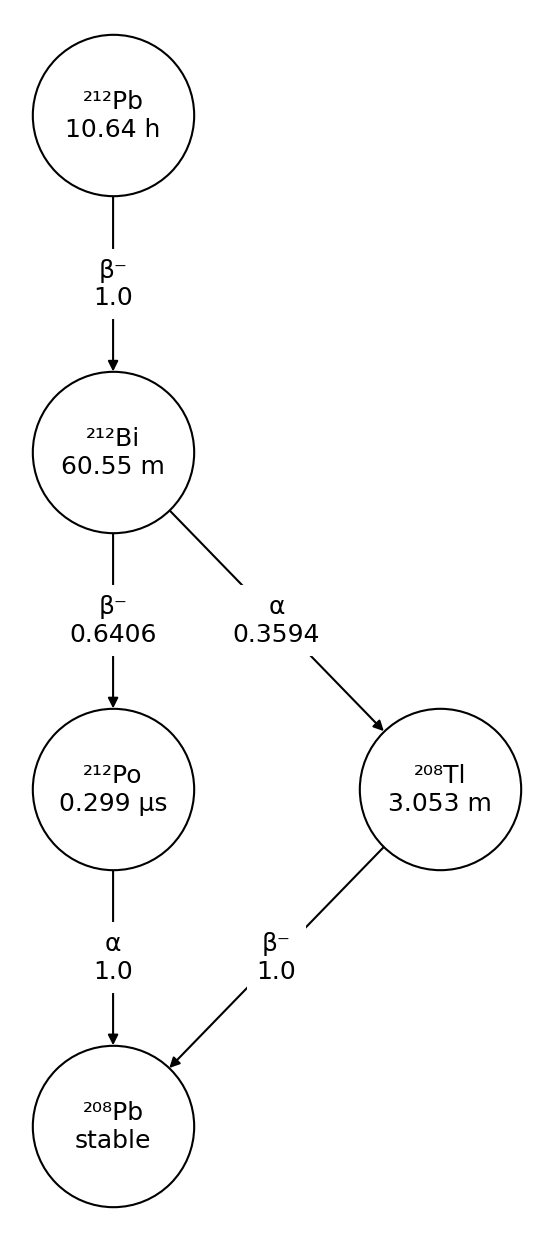

In [321]:
plot_brach(212, 82)

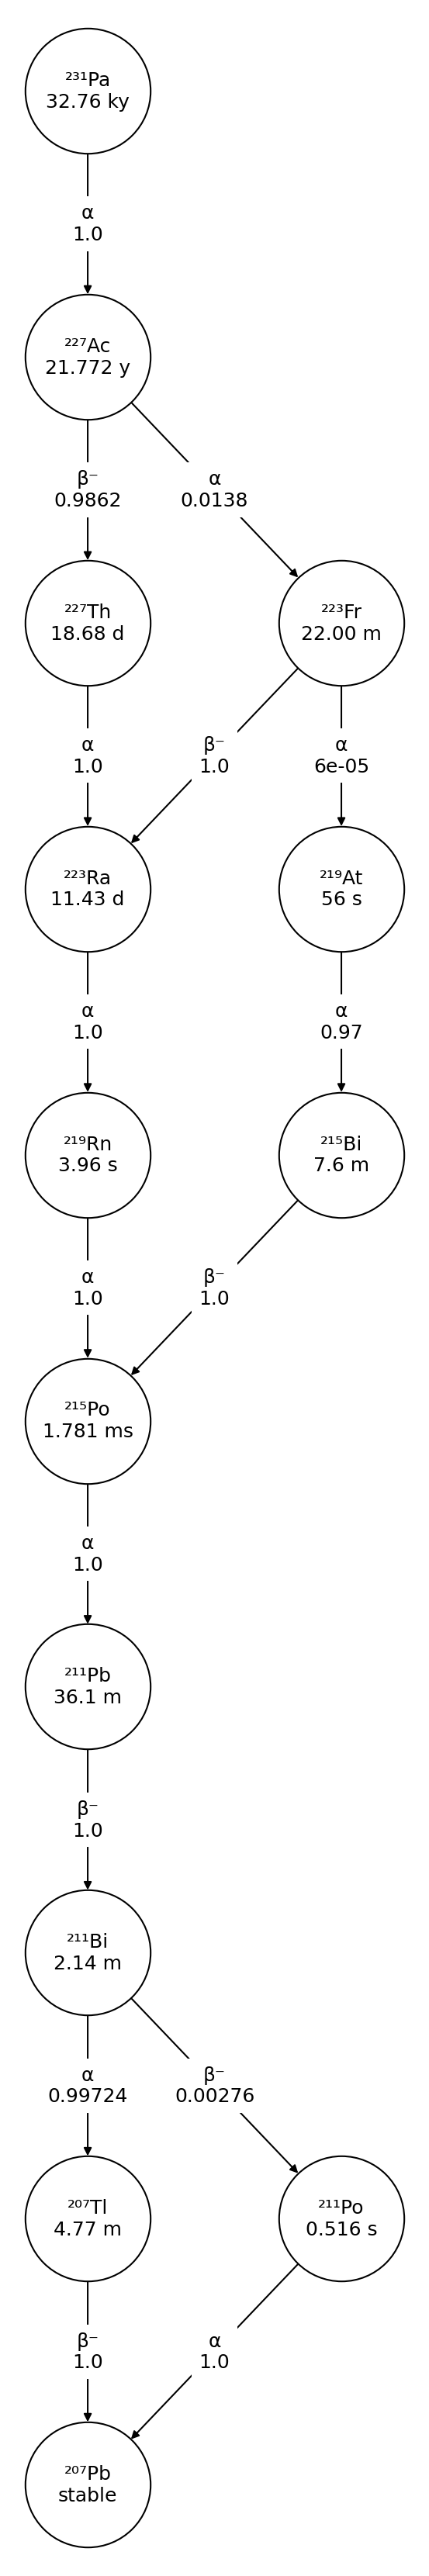

In [320]:
plot_brach(231, 91)

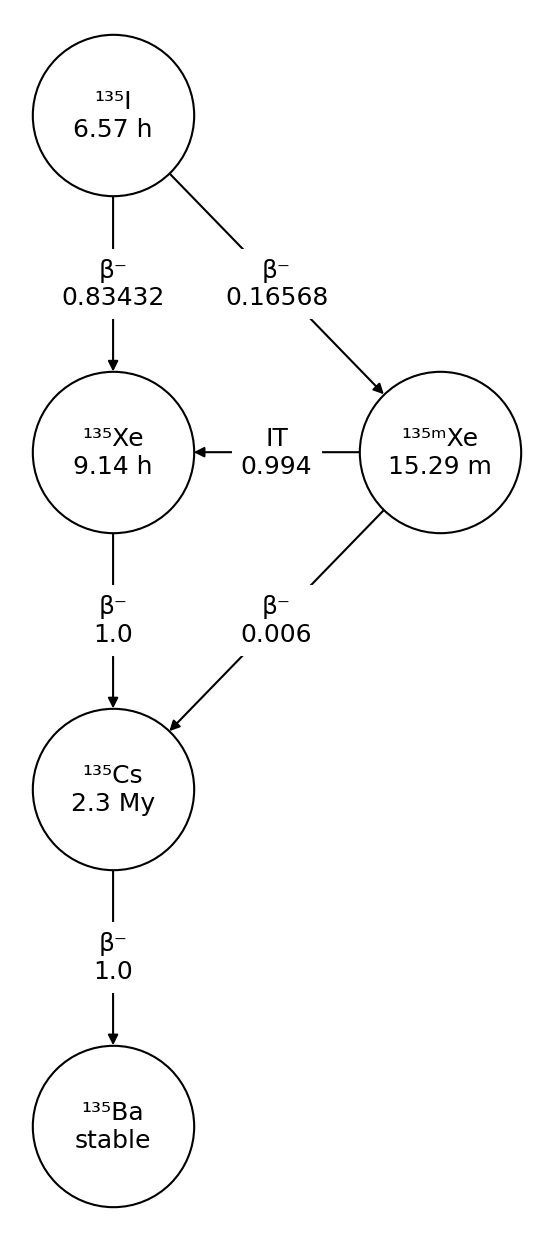

In [234]:
plot_brach(135, 53)

# 20Tungsten1p27mm simulation results 


In [331]:
tungsten = get_tot_df(tungsten1p5_paths).reset_index()
t = tungsten.loc[tungsten["Bq"] > tungsten.describe()["Bq"].loc["25%"]].copy()
t["Half life"] = [catch(A, Z) for A, Z in zip(t["A"], t["Z"])]

In [332]:
# Compare with experimental results
t.loc[(t["A"].isin(["84", "87", "88", "97", "7", "125", "126", "139","183", "211", "214", "219", "22", "68",
                    "18"])) 
      &(t["Z"].isin([35, 36, 4, 41, 53, 54, 58, 56, 75, 83, 86, 11, 31, 9]))] 

,A,Z,Bq,Half life
5,183,75,2.431000e+06,70.0 d
9,7,4,1.467600e+06,53.22 d
59,18,9,1.215457e+03,109.77 m
91,97,41,1.344269e+02,72.1 m
93,84,35,1.317536e+02,31.80 m
131,88,36,5.735114e+01,2.84 h


In [333]:
t[:15] # Top 15

,A,Z,Bq,Half life
0,178,74,6.406000e+06,21.6 d
1,181,74,6.307000e+06,121.2 d
2,177,73,4.418800e+06,56.56 h
3,181,75,4.258090e+06,19.9 h
4,179,74,3.100928e+06,37.05 m
5,183,75,2.431000e+06,70.0 d
6,177,74,2.332136e+06,132 m
7,176,73,1.999058e+06,8.09 h
8,185,74,1.792800e+06,75.1 d
9,7,4,1.467600e+06,53.22 d


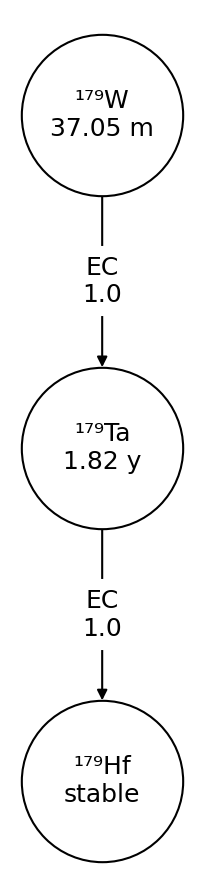

In [312]:
plot_brach(179, 74)

# Reliablity - Brass activation comparison

In [340]:
tbrass = get_tot_df(test_script, number=2).reset_index()
tb = tbrass.loc[tbrass["Bq"] > tbrass.describe()["Bq"].loc["25%"]].copy()
tb["Half life"] = [catch(A, Z) for A, Z in zip(tb["A"], tb["Z"])]

In [341]:
# compare with the other simulation results
tb.loc[(tb["A"].isin(["84", "87", "88", "97", "7", "125", "126", "139","183", "211", "214", "219", "22", "68",
                    "18"])) 
      &(tb["Z"].isin([35, 36, 4, 41, 53, 54, 58, 56, 75, 83, 86, 11, 31, 9]))] 

,A,Z,Bq,Half life
50,68,31,4358.533000,67.71 m
65,7,4,1855.900000,53.22 d
100,97,41,402.697000,72.1 m
158,87,36,79.006161,76.3 m
162,84,35,73.183635,31.80 m
170,88,36,64.741530,2.84 h
188,125,53,38.780000,59.400 d
191,18,9,37.452501,109.77 m
192,183,75,36.700000,70.0 d
207,126,53,24.260000,12.93 d


In [342]:
tb[:15]

,A,Z,Bq,Half life
0,64,29,532594.000000,12.700 h
1,58,27,269500.000000,70.86 d
2,61,29,247771.007683,3.333 h
3,62,29,218961.090000,9.673 m
4,65,30,152360.000000,244.06 d
5,57,27,129990.000000,271.74 d
6,56,27,96350.000000,77.23 d
7,63,30,88321.343640,38.47 m
8,62,30,58450.750000,9.186 h
9,203,82,53090.000000,51.873 h


In [313]:
ntimes_brass_27, nsums_brass_27, nunc_sums_brass_27 = get_val_unc(nbrass1p27_paths)
tungsten_t, tungsten_sums_27, unc_tungsten_sums_27 = get_val_unc(tungsten1p27_paths)


/Users/mikkelsewerin/Documents/fluka_simulations/Full_Sim/20tungsten1p27mm/20tungsten1p27_21_sum.lis
/Users/mikkelsewerin/Documents/fluka_simulations/Full_Sim/20tungsten1p27mm/20tungsten1p27_22_sum.lis
/Users/mikkelsewerin/Documents/fluka_simulations/Full_Sim/20tungsten1p27mm/20tungsten1p27_31_sum.lis
/Users/mikkelsewerin/Documents/fluka_simulations/Full_Sim/20tungsten1p27mm/20tungsten1p27_32_sum.lis
/Users/mikkelsewerin/Documents/fluka_simulations/Full_Sim/20tungsten1p27mm/20tungsten1p27_39_sum.lis
/Users/mikkelsewerin/Documents/fluka_simulations/Full_Sim/20tungsten1p27mm/20tungsten1p27_40_sum.lis


In [305]:

xs = np.linspace(100, 4e5, 20000)
plt.rc("figure", figsize=(10,8), dpi=150)


popt_tungsten_27, perr_tungsten_27 = fit_data(tungsten_sums_27, unc_tungsten_sums_27, prints=True)
npopt_brass_27, nperr_brass_27 = fit_data(nsums_brass_27, nunc_sums_brass_27, guess=[0.5, 9e-10], prints=True)


add_plot(xs, tungsten_sums_27, unc_tungsten_sums_27, popt_tungsten_27, perr_tungsten_27, "tungsten1p27", 'v') 
add_plotx(xs, nsums_brass_27, nunc_sums_brass_27, npopt_brass_27, nperr_brass_27, "brass1p27") 



plt.title("Tot Bq all simulations")
plt.xlabel("Hours")
plt.ylabel("Tot Bq")
#plt.yscale("log")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

ValueError: operands could not be broadcast together with shapes (20,) (14,) 

#### Halflife:  (181, 74) = 121.2 days | (178, 74) = 21.6 days | (177, 73) = 56.56 hours


In [8]:
df_tester = get_tot_df(test_script, number=2)
df_tester[df_tester.values > df_tester.max()[0]/10]

,,Bq
A,Z,
64,29,532594.000000
58,27,269500.000000
61,29,247771.007683
62,29,218961.090000
65,30,152360.000000
57,27,129990.000000
56,27,96350.000000
63,30,88321.343640
62,30,58450.750000


In [9]:
test1, ff2 = get_df_sum(test_script[18], number=2)
find_elements(test1, test1.max().mean()*5, cool_in_sec=True)

Cooling time = 150 Seconds | Threshold = 5293


,A,Z,Bq
3,62,29,46100.0
2,64,29,37700.0
4,61,29,23500.0
6,63,30,13700.0
0,58,27,13600.0
5,65,30,7630.0
1,57,27,6510.0


In [10]:
df_tester[df_tester.values > df_tester.max()[0]/10]

,,Bq
A,Z,
64,29,532594.000000
58,27,269500.000000
61,29,247771.007683
62,29,218961.090000
65,30,152360.000000
57,27,129990.000000
56,27,96350.000000
63,30,88321.343640
62,30,58450.750000


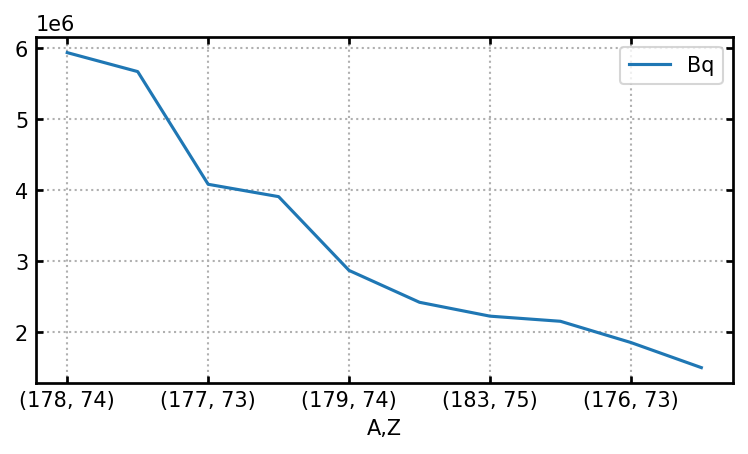

,,Bq
A,Z,
178,74,5.938000e+06
181,74,5.671000e+06
177,73,4.084900e+06
181,75,3.911090e+06
179,74,2.872512e+06
7,4,2.424000e+06
183,75,2.229000e+06
177,74,2.156855e+06
176,73,1.857925e+06


In [11]:
df_sums_tungsten_27 = get_tot_df(tungsten1p27_paths)
df_sums_tungsten_27[:10].plot()
plt.show()
df_sums_tungsten_27[:10]

#### Halflife:  (64, 29) = 12.7 hours | (62, 29) = 9.67 min | (58, 27) = 70.86 days | (7, 4) = 53.22 d


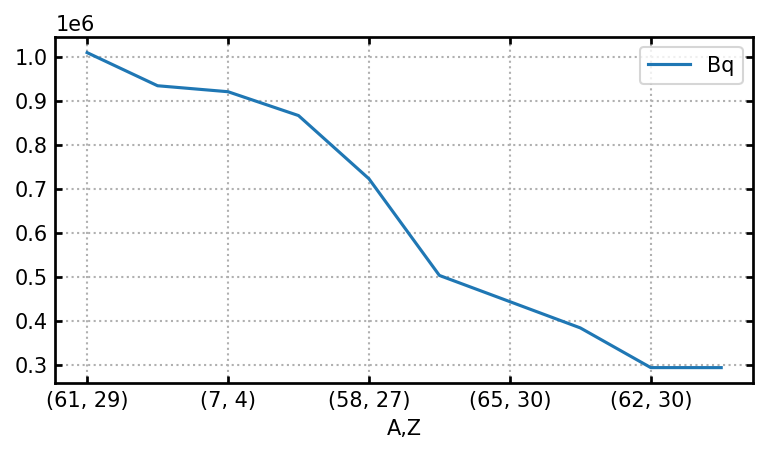

,,Bq
A,Z,
61,29,1.009690e+06
64,29,9.343830e+05
7,4,9.208000e+05
62,29,8.666311e+05
58,27,7.229000e+05
11,6,5.031126e+05
65,30,4.435000e+05
63,30,3.838087e+05
62,30,2.935492e+05


In [12]:
df_sums_brass_27 = get_tot_df(brass1p27_paths)
df_sums_brass_27[:10].plot()
plt.show()
df_sums_brass_27[:10]

from experiment (confirmed, how much), F-18 (c, low), K-40 (background and maybe some created), ZR-89 (n)

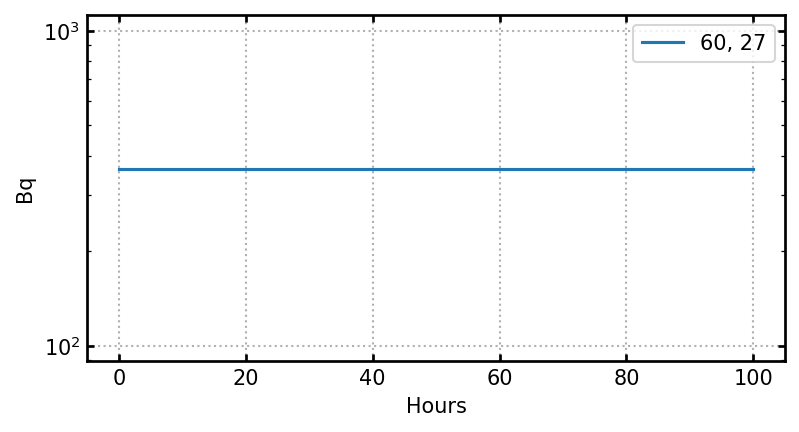

In [13]:
plot_spec(brass1p27_paths, ["60"], ["27"], ylog=True)

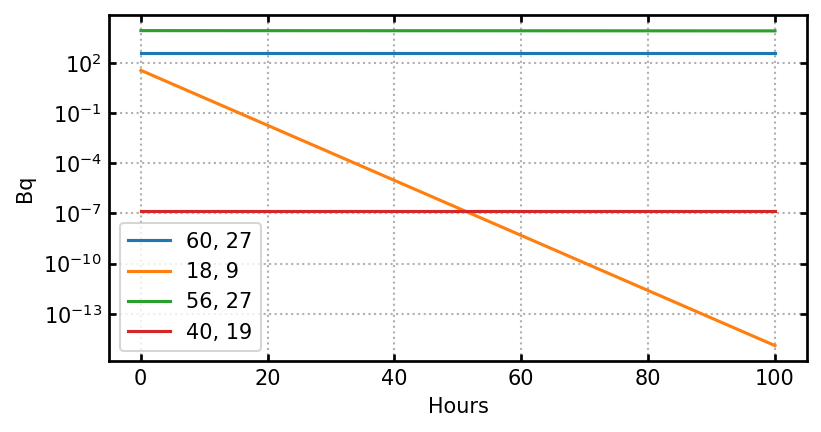

In [14]:
plot_spec(brass1p27_paths, ["60", "18", "56", "40"], ["27", "9", "27", "19"], ylog=True)

In [15]:
ff1, ff2 = get_df_sum(brass1p27_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 32947


,A,Z,Bq
1,7,4,43900.0
0,58,27,35000.0


In [16]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 81718


,A,Z,Bq
0,181,74,279000.0
1,178,74,265000.0
3,7,4,116000.0
2,183,75,108000.0


In [17]:
ff1, ff2 = get_df_sum(brass1p27_paths[8])
find_elements(ff1, ff1.max().mean(), True)

Cooling time = 115200 Seconds | Threshold = 3817


,A,Z,Bq
6,7,4,45600.0
0,58,27,35900.0
4,65,30,22100.0
1,57,27,14600.0
3,64,29,11600.0
2,56,27,8120.0
5,67,31,6910.0


In [18]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[18])
ff1 = find_elements(ff1, ff1.max().mean(), True)
len(ff1), ff1

Cooling time = 150 Seconds | Threshold = 20317


(27,
       A   Z        Bq
 8   179  74  389000.0
 9   178  74  302000.0
 7   181  74  284000.0
 24   11   6  259000.0
 16  181  75  257000.0
 18  179  75  242000.0
 2   177  73  229000.0
 10  177  74  220000.0
 25   13   7  195000.0
 19  178  75  163000.0
 20  177  75  138000.0
 3   176  73  130000.0
 17  180  75  124000.0
 11  176  74  122000.0
 23    7   4  122000.0
 14  183  75  112000.0
 6   185  74   75600.0
 4   175  73   67300.0
 1   179  73   66800.0
 26   15   8   66000.0
 13  184  75   59800.0
 12  175  74   56600.0
 0   175  72   56000.0
 21  176  75   55300.0
 15  182  75   54200.0
 22  175  75   29400.0
 5   174  73   24100.0)

In [19]:
tungsten_t, tungsten_sums_27, unc_tungsten_sums_27 = get_val_unc(tungsten1p27_paths)
tungsten_t1, tungsten_sums_0, unc_tungsten_sums_0 = get_val_unc(tungsten1p0_paths)
tungsten_t2, tungsten_sums_5, unc_tungsten_sums_5 = get_val_unc(tungsten1p5_paths)

times_brass_27, sums_brass_27, unc_sums_brass_27 = get_val_unc(brass1p27_paths)
times_brass20_25, sums_brass20_25, unc_sums_brass20_25 = get_val_unc(brass20_1p25_paths)
times_brass_0, sums_brass_0, unc_sums_brass_0 = get_val_unc(brass1p0_paths)
times_brass_5, sums_brass_5, unc_sums_brass_5 = get_val_unc(brass1p5_paths)

In [21]:
popt_tungsten_27, perr_tungsten_27 = fit_data(tungsten_sums_27, unc_tungsten_sums_27, prints=True)
popt_tungsten_0, perr_tungsten_0 = fit_data(tungsten_sums_0, unc_tungsten_sums_0, prints=True)
popt_tungsten_5, perr_tungsten_5 = fit_data(tungsten_sums_5, unc_tungsten_sums_5, prints=True)

popt_brass_27, perr_brass_27 = fit_data(sums_brass_27, unc_sums_brass_27, prints=True)
popt_brass20_25, perr_brass20_25 = fit_data(sums_brass20_25, unc_sums_brass20_25, prints=True)
popt_brass_0, perr_brass_0 = fit_data(sums_brass_0, unc_sums_brass_0, prints=True)
popt_brass_5, perr_brass_5 = fit_data(sums_brass_5, unc_sums_brass_5, prints=True)

a: 2183317.9421748705     gamma : 0.00015386893693928095 c :  1451346.1155292948
usikkerheder: [2.39279517e+03 4.43312759e-07 1.04100446e+03]
halflife =  1.805288210234358  hours +- 0.005201227177736139
a: 2261613.3033363926     gamma : 0.00020395669322253218 c :  1402939.4388088814
usikkerheder: [2.86102104e+03 6.23536648e-07 1.06147192e+03]
halflife =  1.3619448981490456  hours +- 0.004163739584059292
a: 2167178.752107953     gamma : 0.00012726917501354392 c :  1502677.0393932639
usikkerheder: [2.15197070e+03 3.42926249e-07 1.01390650e+03]
halflife =  2.182600600249171  hours +- 0.005881008003719245
a: 516289.5306650864     gamma : 0.00019710086780300444 c :  187118.75213709867
usikkerheder: [6.22298060e+02 5.92778623e-07 2.18263956e+02]
halflife =  1.4093178831429964  hours +- 0.004238507541591709
a: 1210211.969286993     gamma : 0.00018019596434666407 c :  500211.55417735985
usikkerheder: [1.81934459e+03 6.36718802e-07 6.35275983e+02]
halflife =  1.5415316252221063  hours +- 0.0054

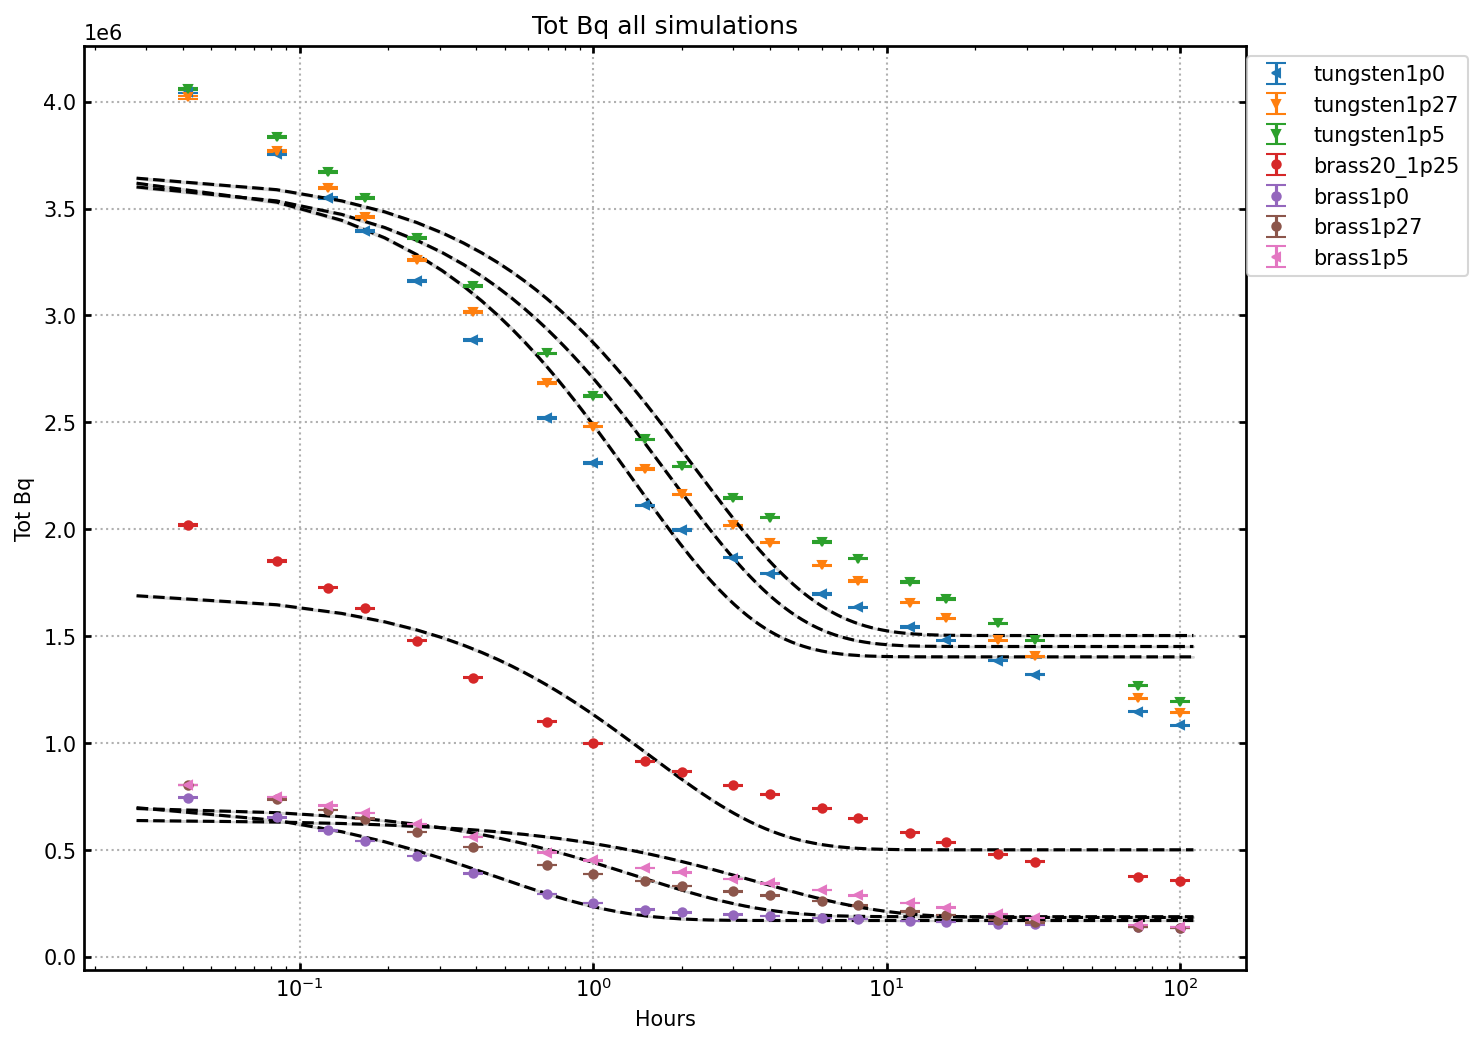

In [23]:
xs = np.linspace(100, 4e5, 2000)
plt.rc("figure", figsize=(10,8), dpi=150)

add_plot(xs, tungsten_sums_0, unc_tungsten_sums_0, popt_tungsten_0, perr_tungsten_0, "tungsten1p0", '<') 
add_plot(xs, tungsten_sums_27, unc_tungsten_sums_27, popt_tungsten_27, perr_tungsten_27, "tungsten1p27", 'v') 
add_plot(xs, tungsten_sums_5, unc_tungsten_sums_5, popt_tungsten_5, perr_tungsten_5, "tungsten1p5", 'v') 
add_plot(xs, sums_brass20_25, unc_sums_brass20_25, popt_brass20_25, perr_brass20_25, "brass20_1p25") 
add_plot(xs, sums_brass_0, unc_sums_brass_0, popt_brass_0, perr_brass_0, "brass1p0")
add_plot(xs, sums_brass_27, unc_sums_brass_27, popt_brass_27, perr_brass_27, "brass1p27") 
add_plot(xs, sums_brass_5, unc_sums_brass_5, popt_brass_5, perr_brass_5, "brass1p5", '<') 


plt.title("Tot Bq all simulations")
plt.xlabel("Hours")
plt.ylabel("Tot Bq")
#plt.yscale("log")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

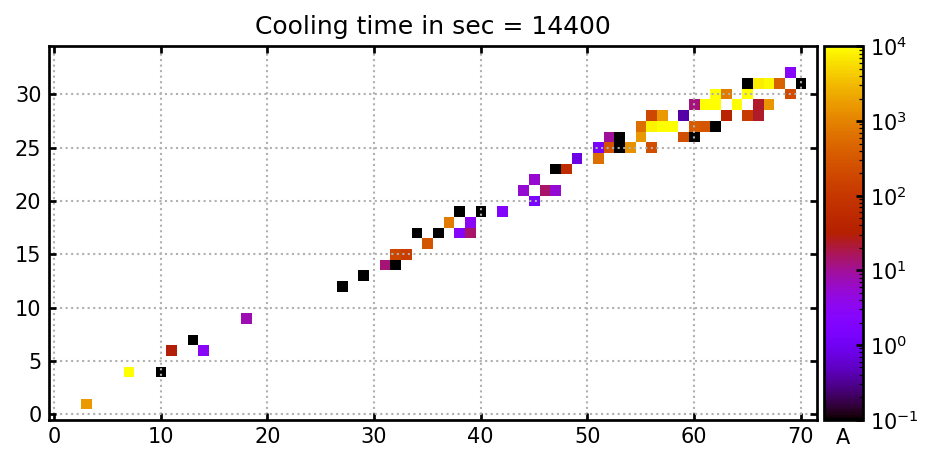

In [24]:
ff1, ff2 = get_df_sum(brass1p27_paths[4])
plot_img(ff1, False, True)

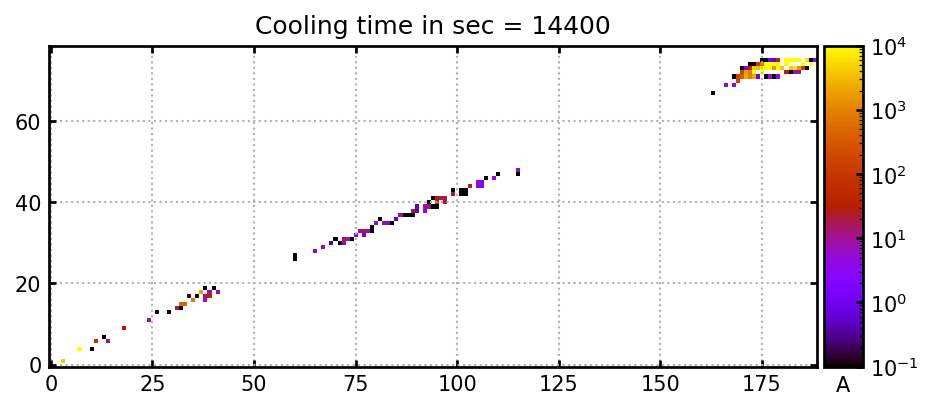

In [25]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[4])
plot_img(ff1, False, True)